In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import os
import shutil, sys                                                                                                                                                    

from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary,alpha="auto",eval_every=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/menis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/menis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/menis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#data = pd.read_json("5campaignNew.json")
data = pd.read_json("7postElection.json")
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
data["vaderScore"] = scores
data = data[data["is_retweet"] == False]

data.rename(index=str, columns={"year": "date_year"},inplace=True)
data.rename(index=str, columns={"month": "date_month"},inplace=True)

data.drop(["hour","in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,date_month,date_year,week_year,labels,vaderScore
favorite_count,1.000000,0.891237,-0.164023,0.185635,-0.164811,0.076417,-0.098971
retweet_count,0.891237,1.000000,-0.089613,0.144045,-0.090638,0.090506,-0.166127
date_month,-0.164023,-0.089613,1.000000,-0.302847,0.984279,-0.032168,0.064430
date_year,0.185635,0.144045,-0.302847,1.000000,-0.302369,0.021680,-0.019233
week_year,-0.164811,-0.090638,0.984279,-0.302369,1.000000,-0.034066,0.066510
labels,0.076417,0.090506,-0.032168,0.021680,-0.034066,1.000000,-0.129911
vaderScore,-0.098971,-0.166127,0.064430,-0.019233,0.066510,-0.129911,1.000000


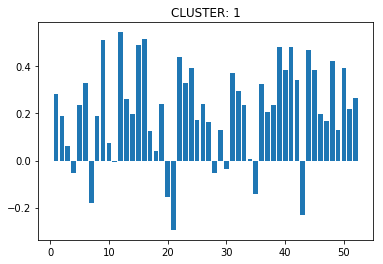

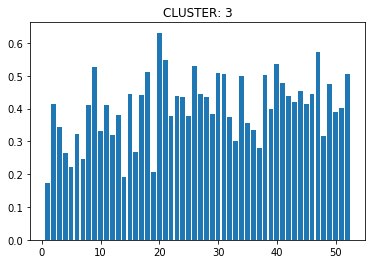

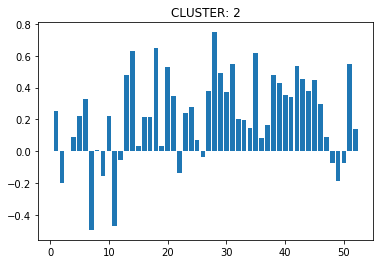

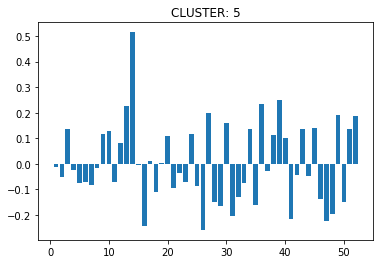

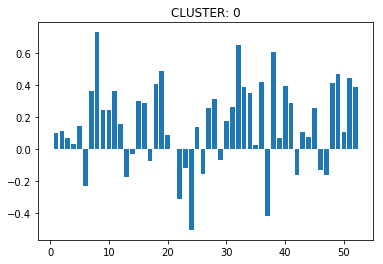

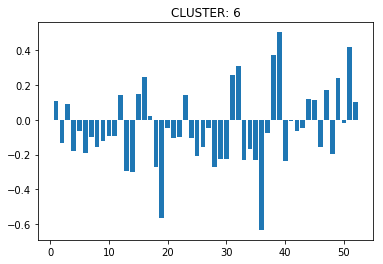

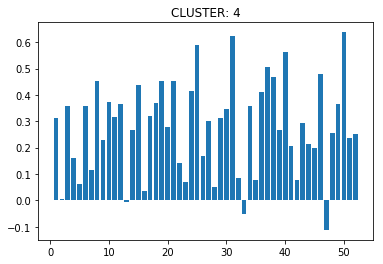

In [3]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()


In [4]:
taggedDescriptions = []
for idx, row in data.iterrows():
    desc = row["noTags_punct"]
    tokens = word_tokenize(desc)
    tagged = pos_tag(tokens)
    taggedDescriptions.append(tagged)
descriptions = []
for item in taggedDescriptions:
    processed = ""
    for el in item:
        if el[1].startswith("N"): #or el[1].startswith("J"):  #se iniziano con N o J sono nomi o aggettivi, quello che ci serve di più
            processed = processed + " " + el[0]
    descriptions.append(processed)

data["n_j"] = descriptions


In [62]:
majorCluster = 0
d1 = data[data["labels"] == majorCluster ]


#stemmed_words = pd.Series(' '.join(d1['modded1_stemmed']).split()).value_counts()
stemmed_words = pd.Series(' '.join(d1["n_j"]).split()).value_counts()
print(stemmed_words)

stemmed_words = stemmed_words[3:]
stemmed_words = stemmed_words[stemmed_words > 2]
#d1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))
d1["n_j"] = d1["n_j"].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

Series([], dtype: int64)


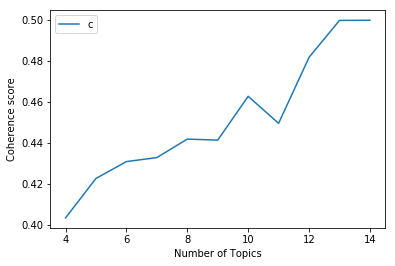

14


In [55]:
from gensim.corpora.dictionary import Dictionary

tokenizer = RegexpTokenizer(r'\w+')

#corpus = d1["m"].tolist()
corpus = d1["n_j"].tolist()
#print(len(corpus))
corp = []
for string in corpus:
    tokens = tokenizer.tokenize(string)
    corp.append(tokens)

common_dictionary = Dictionary(corp)
common_corpus = [common_dictionary.doc2bow(text) for text in corp]
tfidf = TfidfModel(common_corpus)
tfidf_corpus = tfidf[common_corpus]

start,stop,step=4,15,1
nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)

print(nTopics)


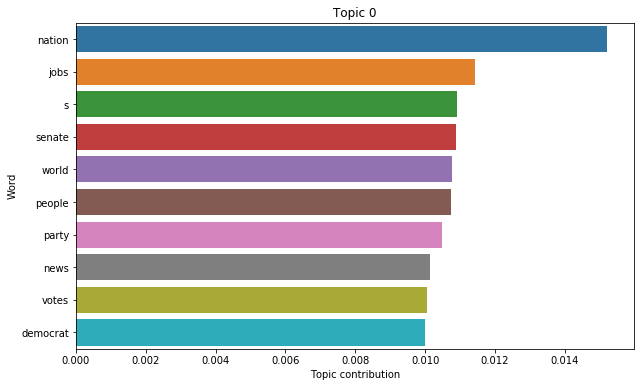

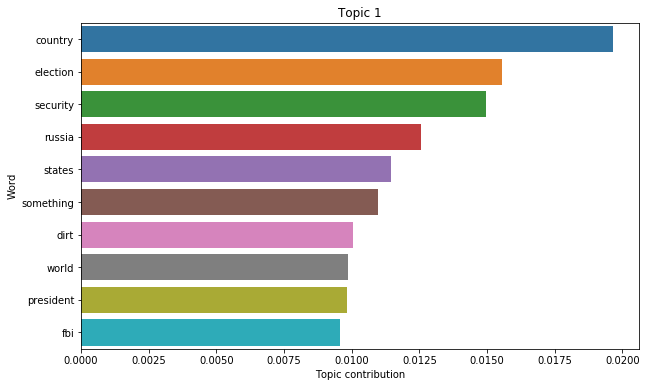

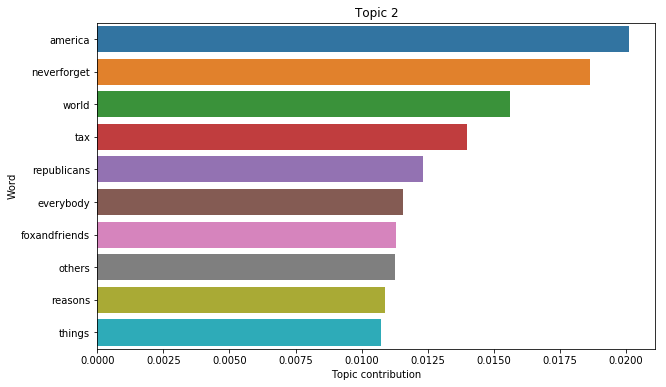

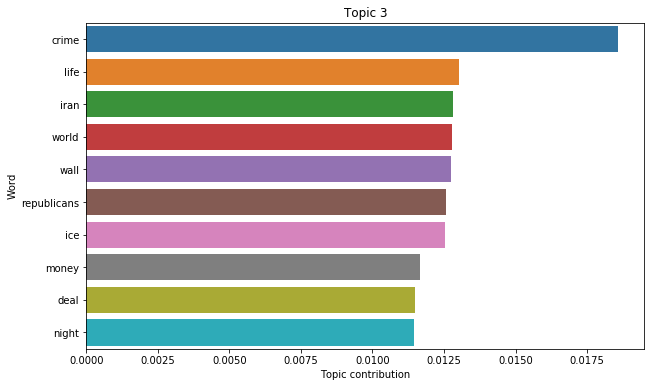

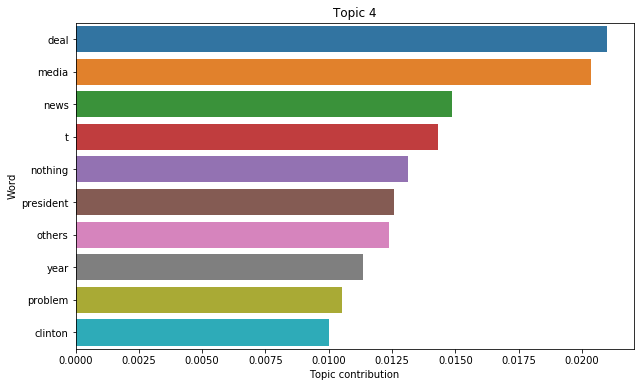

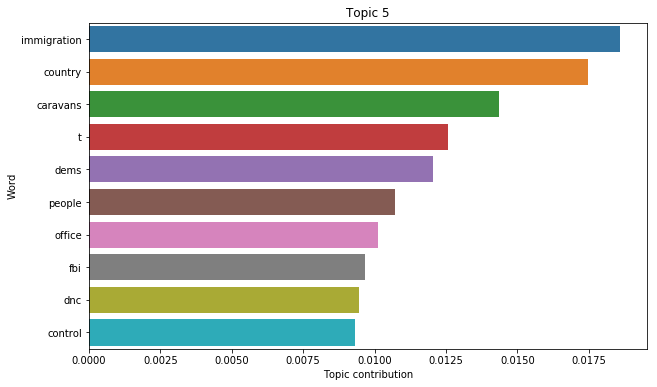

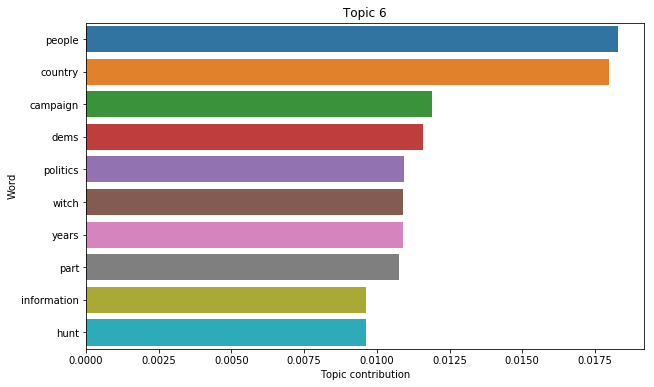

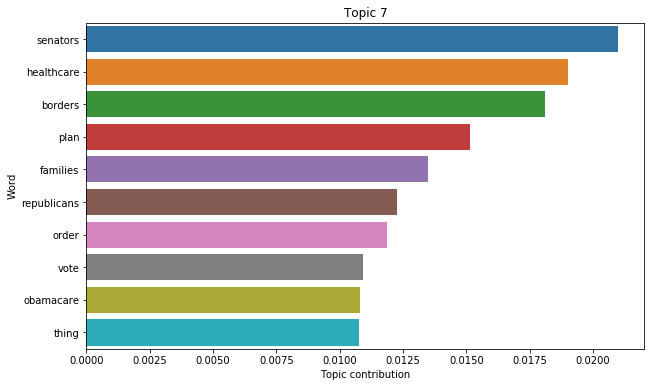

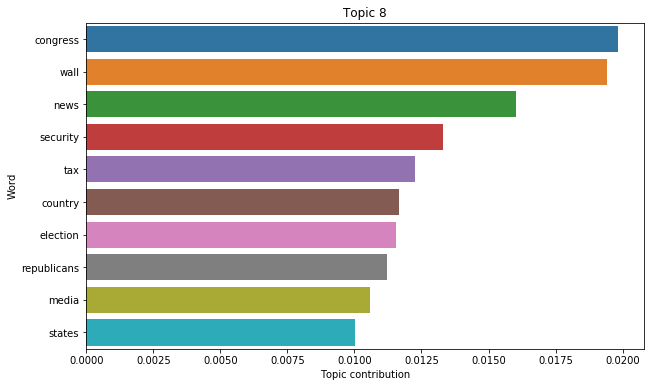

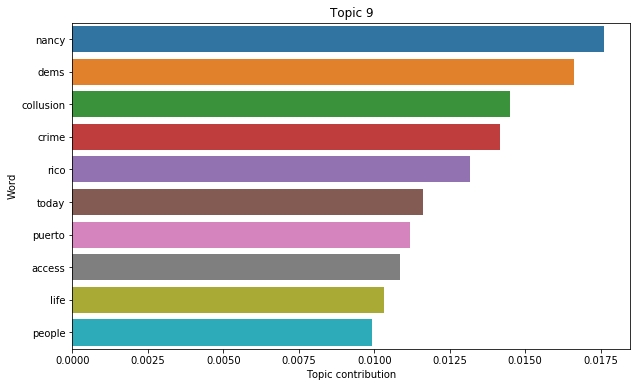

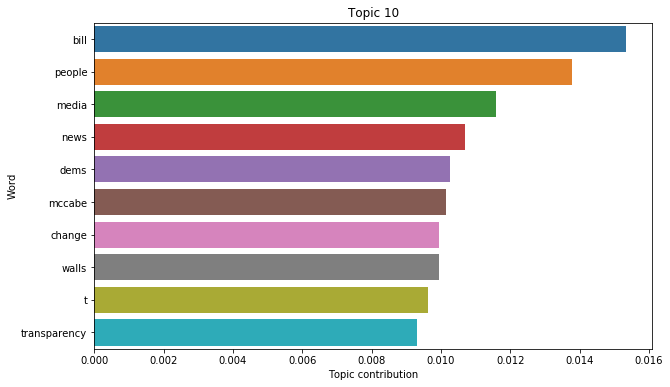

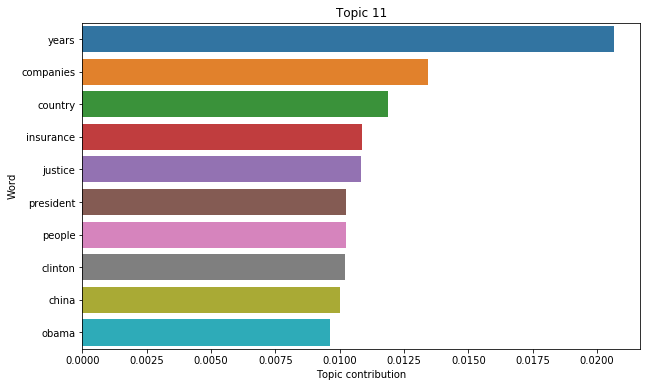

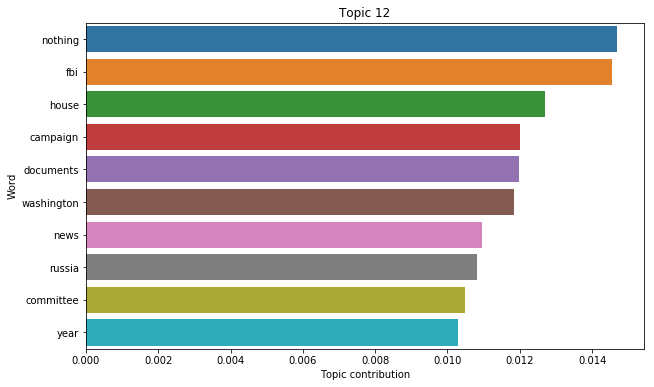

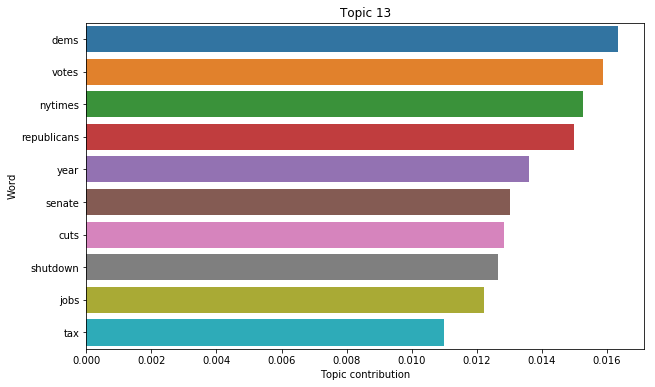

687 687
topics_count [76, 67, 66, 58, 53, 50, 47, 44, 41, 41, 39, 36, 36, 33]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
#genera cartella
#path = "campaign/cluster"+str(majorCluster)
path = 'post/cluster'+str(majorCluster)
if os.path.exists(path):
    shutil.rmtree(path)
os.mkdir(path)

#nTopics = 5
lda = LdaModel(tfidf_corpus, num_topics=nTopics, id2word=common_dictionary,alpha="auto",eval_every=2)

topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False)
#print(g)
topicFigures = []
for topic in topics:
    words = []
    weights = []
    for word in topic[1]:
        if abs(word[1]) > 0.001:
            words.append(word[0])
            #prendi valore assoluto perchè positivo/negativo non ha senso 
            weights.append(abs(word[1]))
    labels = words
    sizes = weights
    fig = plt.figure(figsize=(10, 6))
    plt.title("Topic " + str(topic[0]),figure=fig)
    sns.barplot(x=weights, y=words,figure=fig)
    plt.xlabel("Topic contribution",figure=fig)
    plt.ylabel("Word",figure=fig)
    plt.savefig(path + '/c'+ str(majorCluster) + 't'+ str(topic[0])+ 'weights.png')
    plt.show()     
    topicFigures.append(fig)
topicColumn = []
topicList = {}

for el in tfidf_corpus:
    vector = lda.get_document_topics(el)
    #get topic
    m = max(y for (x,y) in vector)
    ind = [x for x, y in enumerate(vector) if y[1] == m][0]
    #print(ind,m)
    if ind not in topicList:
        topicList[ind] = 1
    else: 
        topicList[ind] += 1
    topicColumn.append(ind)

print(len(topicColumn),len(d1))
d1["topic"] = topicColumn
#print(topicColumn)
print("topics_count",d1["topic"].value_counts().tolist())



(array([ 72.,  36.,  47.,  82.,  76.,  44., 111.,  36.,  66., 117.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <a list of 10 Patch objects>)

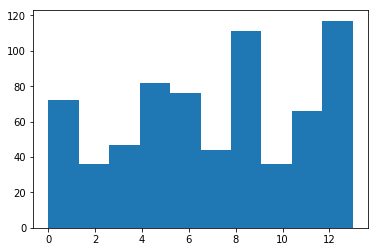

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  
#corpus = d1["m"].tolist()
corpus = d1["n_j"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

d1.reset_index(inplace=True,drop=True)
res = pd.concat([d1,c], axis=1)
#res1 = res.drop(["m","week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1)
res1 = res.drop(["n_j","week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1)

dataWithText = res.drop(["week_year","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
#dataWithText = res
res1.columns
plt.hist(res1["topic"])

2 0.6625460622878354
3 0.6573127165754733
4 0.5776686783119251
5 0.5015266301750463
6 0.4424661543134212
7 0.38797504812486416
8 0.38531731441039047
9 0.3816399088991455
10 0.35813210930303235
11 0.32830502216636104
12 0.3246011547014425
13 0.3209141751689507
14 0.2852093720500028
15 0.2874680881369473
16 0.2878550047955505
17 0.2761364396626377
18 0.26988994461576754
19 0.2616047948813089
20 0.25531710775192773
21 0.24733002982791222


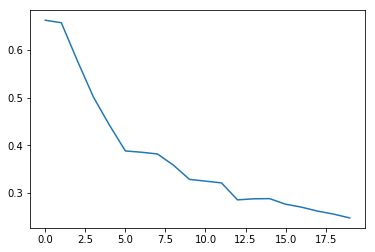

In [58]:
sil = []
for c in range(2,22):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)
plt.plot([x for x in range(0,len(sil))],sil)

In [59]:
res1 = res.drop(["n_j","week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1)

dataWithText = res.drop(["week_year","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

print(res1.columns)
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=10) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)

Index(['date_year', 'vaderScore', 'topic', 'abc', 'abuse', 'access', 'act',
       'action', 'address', 'administration',
       ...
       'women', 'words', 'work', 'workers', 'world', 'wow', 'year', 'years',
       'yesterday', 'york'],
      dtype='object', length=497)
0.35813210930303235


In [60]:
res1["labels"] = labels
dataWithText["labels"] = labels

CLUSTER 1
111
2018    58
2017    32
2019    21
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


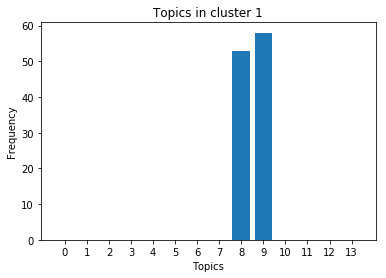

Topic 8:  congress wall news security tax country election republicans media states
Topic 9:  nancy dems collusion crime rico today puerto access life people


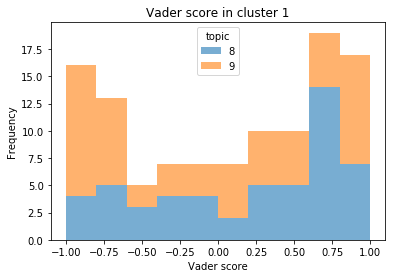

CLUSTER 0
117
2018    68
2017    25
2019    24
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


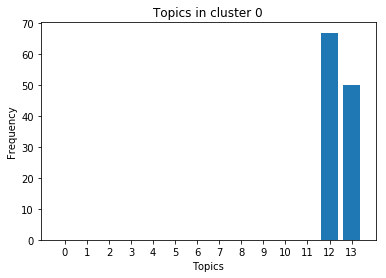

Topic 12:  nothing fbi house campaign documents washington news russia committee year
Topic 13:  dems votes nytimes republicans year senate cuts shutdown jobs tax


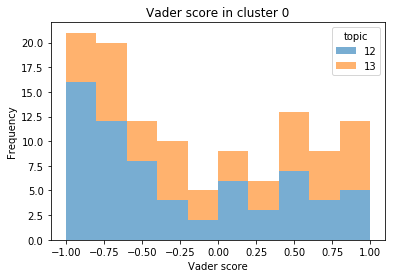

CLUSTER 2
102
2018    59
2017    30
2019    13
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


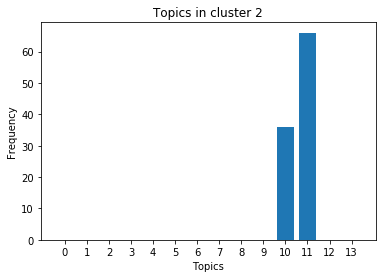

Topic 10:  bill people media news dems mccabe change walls t transparency
Topic 11:  years companies country insurance justice president people clinton china obama


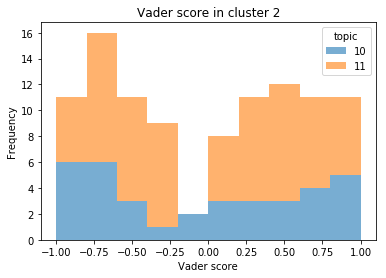

CLUSTER 5
63
2018    31
2017    24
2019     8
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


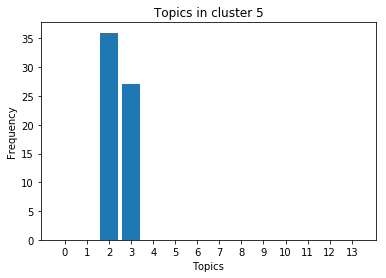

Topic 2:  america neverforget world tax republicans everybody foxandfriends others reasons things
Topic 3:  crime life iran world wall republicans ice money deal night


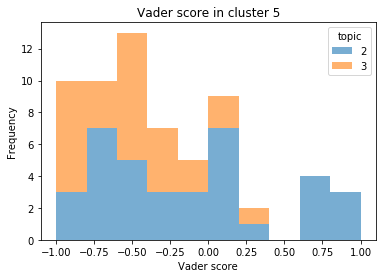

CLUSTER 9
26
2017    14
2018    10
2019     2
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


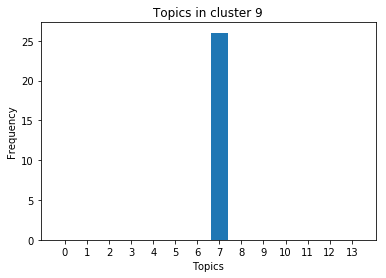

Topic 7:  senators healthcare borders plan families republicans order vote obamacare thing


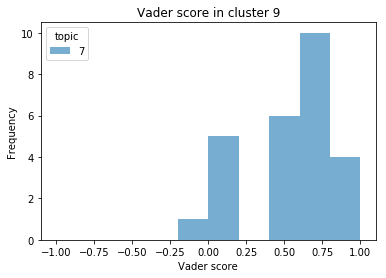

CLUSTER 6
44
2018    24
2017    16
2019     4
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


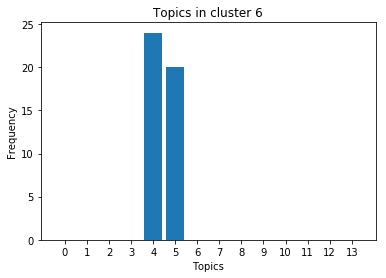

Topic 4:  deal media news t nothing president others year problem clinton
Topic 5:  immigration country caravans t dems people office fbi dnc control


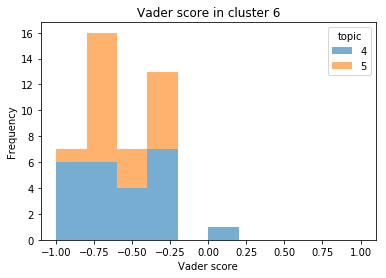

CLUSTER 4
75
2018    33
2017    27
2019    15
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


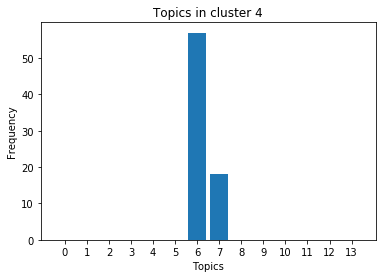

Topic 6:  people country campaign dems politics witch years part information hunt
Topic 7:  senators healthcare borders plan families republicans order vote obamacare thing


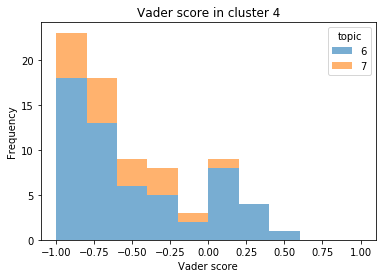

CLUSTER 3
72
2018    46
2017    17
2019     9
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


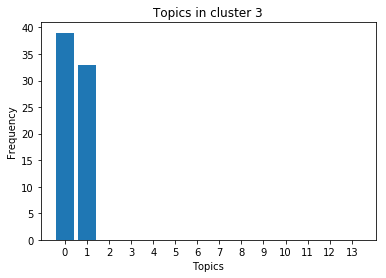

Topic 0:  nation jobs s senate world people party news votes democrat
Topic 1:  country election security russia states something dirt world president fbi


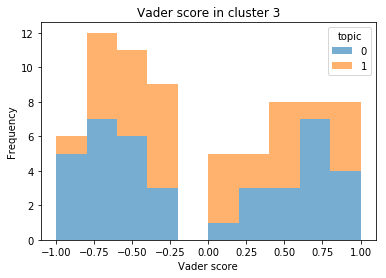

CLUSTER 7
37
2018    25
2017     9
2019     3
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


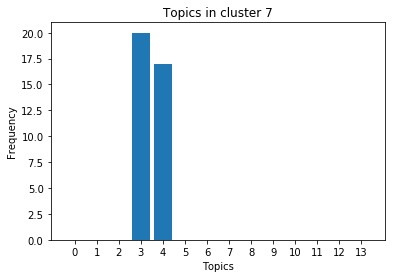

Topic 3:  crime life iran world wall republicans ice money deal night
Topic 4:  deal media news t nothing president others year problem clinton


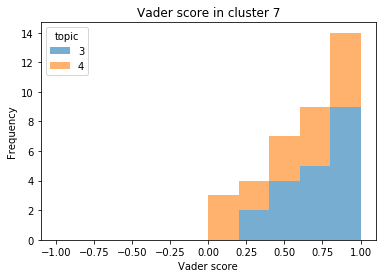

CLUSTER 8
40
2018    26
2017    11
2019     3
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


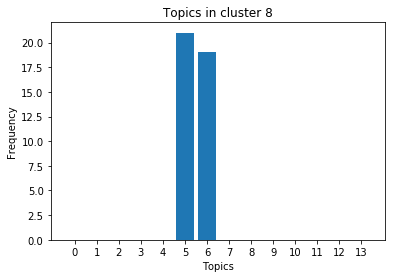

Topic 5:  immigration country caravans t dems people office fbi dnc control
Topic 6:  people country campaign dems politics witch years part information hunt


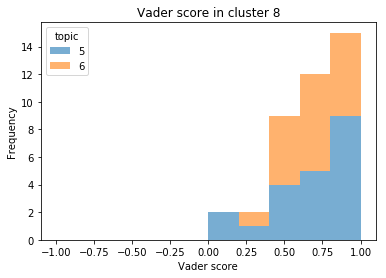

In [61]:

for cluster in res1["labels"].unique():
    path = 'post/cluster'+str(majorCluster)+'/subcluster'+ str(cluster)
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

    g1 = res1[res1["labels"] == cluster]

   # temp = dataWithText[dataWithText["labels"] == cluster]


    #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
    #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")
    print("CLUSTER " + str(cluster))
    print(len(g1))
    print(g1["date_year"].value_counts())
    print(g1["date_year"].unique().tolist())
    print("anni nel cluster ", len(g1["date_year"].unique().tolist()))
    #print(temp["week_year"].unique().tolist())
   # print("numero di settimane in cluster", len(temp["week_year"].unique().tolist()))

    #plt.hist(g1["topic"],bins=[0,1,2,3,4,5,6,7,8,9,10])
    #plt.title("topicdistrib in cluster " + str(cluster))
    #plt.show()
    
    #plot bar chart with topics
    counts = g1["topic"].value_counts()
    arr = [0 for x in range(0,nTopics)]
    topicStrings = []
    for i in range(0,len(arr)):
        if i in counts:
            arr[i] = counts[i]
            topicStr = ""
            for el in topics[i][1]:
                topicStr += " " + el[0] 
            topicStrings.append([i,topicStr])
    ind = [i for i in range(0,nTopics)]    
    plt.bar(ind,arr)
    plt.title("Topics in cluster " + str(cluster))
    plt.xticks(np.arange(0, nTopics, step=1))
    plt.xlabel("Topics")
    plt.ylabel("Frequency")
    plt.savefig(path + '/sub'+ str(cluster) + 'topicDistribution'+ '.png')
    plt.show()
    
    for el in topicStrings:
        print("Topic " + str(el[0]) + ": " + el[1])

    g1.pivot(columns='topic').vaderScore.plot(kind = 'hist',alpha=0.6,stacked=True,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
    plt.title("Vader score in cluster " + str(cluster) )
    plt.xlabel("Vader score")
    plt.savefig(path + '/sub'+ str(cluster) + 'VaderScore'+ '.png')
    plt.show()


    #save info in text file
    file = open(path + "/generalInfo.txt","w")
    
    file.write("cluster "+str(cluster) +" lunghezza " + str(len(g1)) + "\n") 
    file.write("Mean vader: " + str(g1["vaderScore"].mean()))
    file.write("NUMBER OF TOPICS FOR CLUSTER "+ str(cluster)+ " : "+ str(nTopics) + "\n") 
    file.write(d1["date_year"].value_counts().to_string()+ "\n")
    file.close()

